In [ ]:
!pip install torchvision timm -q

In [ ]:
import os
import random
import time

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# ===== 하이퍼파라미터 & 경로 설정 =====
batch_size = 16          # 16 or 8
num_epochs = 20
lr = 1e-4
image_size = 224
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 42

print("Device:", device)

# chest_xray 경로
DATA_ROOT = "/content/chest_xray/chest_xray"
train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "val")
test_dir  = os.path.join(DATA_ROOT, "test")
print(train_dir, val_dir, test_dir)


Device: cuda
/content/chest_xray/chest_xray/train /content/chest_xray/chest_xray/val /content/chest_xray/chest_xray/test


In [ ]:
# ===== 시드 고정 =====
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)


In [ ]:
# ===== 데이터 변환(전처리 + 증강) 정의 =====
# ImageNet 기준 평균/표준편차
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile, os

zip_path = "/content/drive/MyDrive/archive.zip"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content/chest_xray")

!ls /content
!ls /content/chest_xray


chest_xray  drive  sample_data
chest_xray


In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir,   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(test_dir,  transform=val_test_transform)

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['NORMAL', 'PNEUMONIA']


In [ ]:
# ===== DataLoader 정의 =====
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True)


In [ ]:
# ===== EfficientNet-B0 불러오기 (torchvision) =====
base_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# 마지막 classifier 수정: 1000 -> 1 로짓
in_features = base_model.classifier[1].in_features
base_model.classifier[1] = nn.Linear(in_features, 1)

model = base_model.to(device)

# 파라미터 수 확인
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 178MB/s]


Total parameters: 4,008,829


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()         # 출력이 로짓이므로
optimizer = Adam(model.parameters(), lr=lr)


In [ ]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_logits = []

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # (B,1)

        optimizer.zero_grad()
        logits = model(images)          # (B,1)
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        all_labels.append(labels.detach().cpu().numpy())
        all_logits.append(logits.detach().cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_logits = np.vstack(all_logits)

    # 로짓 → 확률 → 0/1
    probs = torch.sigmoid(torch.tensor(all_logits)).numpy()
    preds = (probs > 0.5).astype(int)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, preds)
    try:
        epoch_auc = roc_auc_score(all_labels, probs)
    except:
        epoch_auc = float("nan")

    return epoch_loss, epoch_acc, epoch_auc


def eval_one_epoch(model, loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Eval", leave=False):
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            logits = model(images)
            loss = loss_fn(logits, labels)

            running_loss += loss.item() * images.size(0)
            all_labels.append(labels.detach().cpu().numpy())
            all_logits.append(logits.detach().cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_logits = np.vstack(all_logits)

    probs = torch.sigmoid(torch.tensor(all_logits)).numpy()
    preds = (probs > 0.5).astype(int)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_labels, preds)
    try:
        epoch_auc = roc_auc_score(all_labels, probs)
    except:
        epoch_auc = float("nan")

    return epoch_loss, epoch_acc, epoch_auc, all_labels, preds, probs


In [ ]:
best_val_auc = -1
best_state_dict = None

train_history = {"loss": [], "acc": [], "auc": []}
val_history   = {"loss": [], "acc": [], "auc": []}

for epoch in range(1, num_epochs+1):
    print(f"\n===== Epoch {epoch}/{num_epochs} =====")
    start_time = time.time()

    train_loss, train_acc, train_auc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc, val_auc, _, _, _ = eval_one_epoch(model, val_loader, loss_fn, device)

    train_history["loss"].append(train_loss)
    train_history["acc"].append(train_acc)
    train_history["auc"].append(train_auc)

    val_history["loss"].append(val_loss)
    val_history["acc"].append(val_acc)
    val_history["auc"].append(val_auc)

    elapsed = time.time() - start_time

    print(f"Train  - loss: {train_loss:.4f}, acc: {train_acc:.4f}, auc: {train_auc:.4f}")
    print(f"Val    - loss: {val_loss:.4f}, acc: {val_acc:.4f}, auc: {val_auc:.4f}")
    print(f"Epoch time: {elapsed/60:.1f} min")

    # best epoch 선정 기준: val_auc 기준 (마음대로 바꿔도 됨)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state_dict = model.state_dict()
        print(">> Best model updated.")



===== Epoch 1/20 =====


Train  - loss: 0.1820, acc: 0.9375, auc: 0.9789
Val    - loss: 0.5898, acc: 0.6250, auc: 1.0000
Epoch time: 1.5 min
>> Best model updated.

===== Epoch 2/20 =====


Train  - loss: 0.0710, acc: 0.9741, auc: 0.9959
Val    - loss: 0.1143, acc: 1.0000, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 3/20 =====


Train  - loss: 0.0554, acc: 0.9814, auc: 0.9973
Val    - loss: 0.2613, acc: 0.8125, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 4/20 =====


Train  - loss: 0.0431, acc: 0.9837, auc: 0.9986
Val    - loss: 0.0668, acc: 1.0000, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 5/20 =====


Train  - loss: 0.0334, acc: 0.9895, auc: 0.9991
Val    - loss: 0.0275, acc: 1.0000, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 6/20 =====


Train  - loss: 0.0280, acc: 0.9896, auc: 0.9994
Val    - loss: 0.1849, acc: 0.9375, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 7/20 =====


Train  - loss: 0.0208, acc: 0.9927, auc: 0.9997
Val    - loss: 0.0687, acc: 0.9375, auc: 1.0000
Epoch time: 1.5 min

===== Epoch 8/20 =====


Train  - loss: 0.0235, acc: 0.9921, auc: 0.9995
Val    - loss: 0.1262, acc: 1.0000, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 9/20 =====


Train  - loss: 0.0175, acc: 0.9927, auc: 0.9997
Val    - loss: 0.0304, acc: 1.0000, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 10/20 =====


Train  - loss: 0.0187, acc: 0.9941, auc: 0.9997
Val    - loss: 0.0716, acc: 1.0000, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 11/20 =====


Train  - loss: 0.0180, acc: 0.9937, auc: 0.9998
Val    - loss: 0.0404, acc: 1.0000, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 12/20 =====


Train  - loss: 0.0066, acc: 0.9975, auc: 1.0000
Val    - loss: 0.0260, acc: 1.0000, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 13/20 =====


Train  - loss: 0.0114, acc: 0.9958, auc: 0.9999
Val    - loss: 0.1105, acc: 0.9375, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 14/20 =====


Train  - loss: 0.0101, acc: 0.9962, auc: 0.9999
Val    - loss: 0.4407, acc: 0.9375, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 15/20 =====


Train  - loss: 0.0111, acc: 0.9965, auc: 0.9999
Val    - loss: 0.0231, acc: 1.0000, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 16/20 =====


Train  - loss: 0.0098, acc: 0.9965, auc: 0.9999
Val    - loss: 0.0986, acc: 0.9375, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 17/20 =====


Train  - loss: 0.0094, acc: 0.9967, auc: 0.9999
Val    - loss: 0.1855, acc: 0.9375, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 18/20 =====


Train  - loss: 0.0129, acc: 0.9956, auc: 0.9998
Val    - loss: 0.0529, acc: 1.0000, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 19/20 =====


Train  - loss: 0.0062, acc: 0.9975, auc: 1.0000
Val    - loss: 0.1862, acc: 0.8750, auc: 1.0000
Epoch time: 1.4 min

===== Epoch 20/20 =====


Train  - loss: 0.0058, acc: 0.9969, auc: 1.0000
Val    - loss: 0.4354, acc: 0.8125, auc: 1.0000
Epoch time: 1.4 min


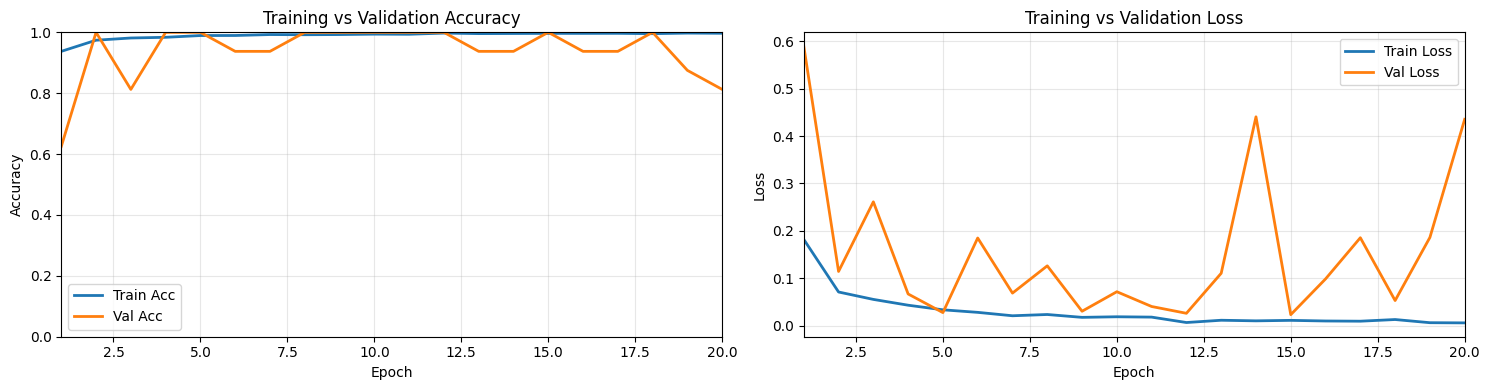

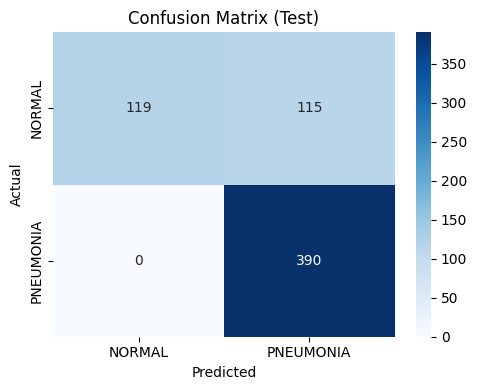

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


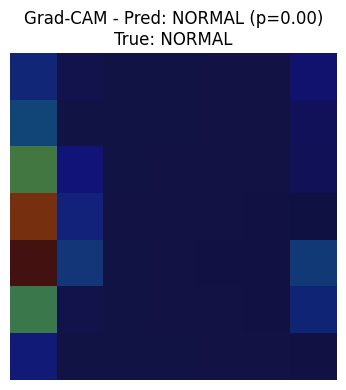

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# =========================
# 0. Test 전체 예측 (y_true, y_probs, y_pred 구하기)
# =========================
model.eval()
all_labels = []
all_logits = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        logits = model(images)

        all_labels.append(labels.cpu().numpy())
        all_logits.append(logits.cpu().numpy())

y_true = np.vstack(all_labels)          # (N, 1)
logits = np.vstack(all_logits)          # (N, 1)

# 로짓 -> 확률(sigmoid) -> 이진 예측
y_probs = torch.sigmoid(torch.tensor(logits)).numpy().reshape(-1)  # (N,)
y_true  = y_true.reshape(-1)                                       # (N,)
y_pred  = (y_probs > 0.5).astype(int)                              # (N,)

class_names = ["NORMAL", "PNEUMONIA"]  # 클래스 이름 고정

# =========================
# 1. 학습 곡선: Accuracy
# =========================
epochs = range(1, len(train_history["acc"]) + 1)

plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_history["acc"], label="Train Acc", linewidth=2)
plt.plot(epochs, val_history["acc"],   label="Val Acc",   linewidth=2)
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(1, len(train_history["acc"]))
plt.ylim(0, 1)                      # Accuracy 0~1 정규화
plt.grid(alpha=0.3)
plt.legend()

# =========================
# 2. 학습 곡선: Loss
# =========================
plt.subplot(1,2,2)
plt.plot(epochs, train_history["loss"], label="Train Loss", linewidth=2)
plt.plot(epochs, val_history["loss"],   label="Val Loss",   linewidth=2)
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")                  # Loss는 값 그대로
plt.xlim(1, len(train_history["loss"]))
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# =========================
# 3. Confusion Matrix (Test 기준)
#    - 행 = 실제(Actual), 열 = 예측(Predicted)
# =========================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

# =========================
# 4. Grad-CAM (테스트 이미지 1장)
# =========================

# ---- Grad-CAM을 위한 후크 설정 ----
# EfficientNet-B0의 마지막 conv 블록을 타겟으로 사용
target_layer = model.features[-1][0]

activations = []
grads = []

def forward_hook(module, inp, out):
    activations.append(out.detach())

def backward_hook(module, grad_in, grad_out):
    grads.append(grad_out[0].detach())

h_fwd = target_layer.register_forward_hook(forward_hook)
h_bwd = target_layer.register_backward_hook(backward_hook)

# ---- 테스트 이미지 1장 가져오기 ----
model.eval()
images, labels = next(iter(test_loader))
img = images[0:1].to(device)           # (1, C, H, W)
true_label = int(labels[0].item())

# ---- Forward & Backward ----
logits = model(img)                    # (1,1)
prob = torch.sigmoid(logits)[0].item()
pred_class = int(prob > 0.5)           # 0: NORMAL, 1: PNEUMONIA

model.zero_grad()
logits[0].backward()

# ---- Grad-CAM 계산 ----
A = activations[0][0]   # (C, H, W)
G = grads[0][0]         # (C, H, W)

weights = G.mean(dim=(1, 2))          # (C,)
cam = (weights[:, None, None] * A).sum(dim=0)  # (H, W)
cam = torch.relu(cam)

cam -= cam.min()
if cam.max() > 0:
    cam /= cam.max()
cam_np = cam.cpu().numpy()

# ---- 원본 이미지 복원 (denormalize, 0~1) ----
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

img_np = img.detach().cpu().squeeze().permute(1, 2, 0).numpy()
img_np = img_np * std + mean
img_np = np.clip(img_np, 0, 1)

# ---- Grad-CAM 시각화 ----
plt.figure(figsize=(5,4))
plt.imshow(img_np)
plt.imshow(cam_np, cmap="jet", alpha=0.4)
plt.axis("off")
plt.title(
    f"Grad-CAM - Pred: {class_names[pred_class]} (p={prob:.2f})\n"
    f"True: {class_names[true_label]}"
)
plt.tight_layout()
plt.show()

# 후크 해제
h_fwd.remove()
h_bwd.remove()


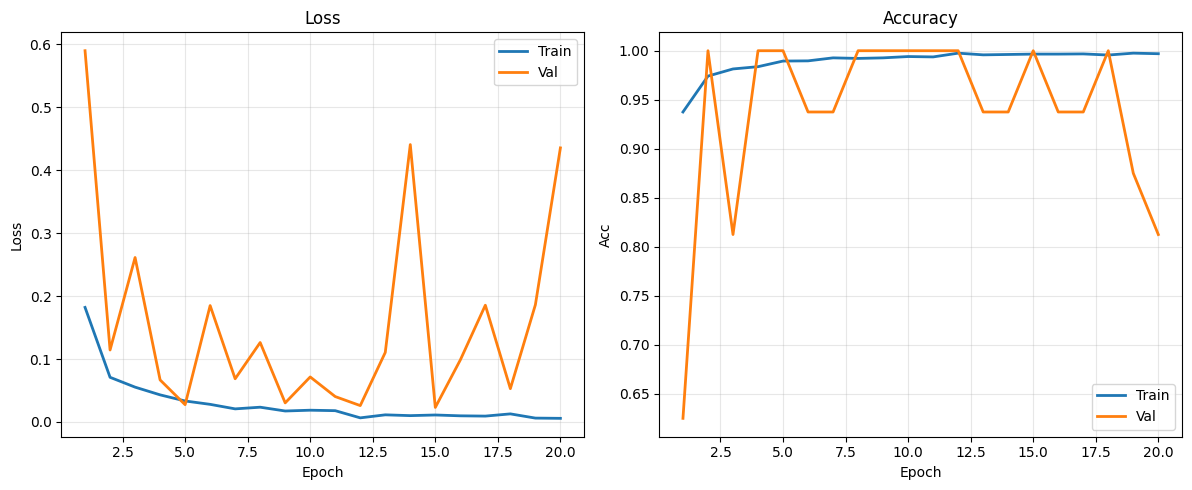

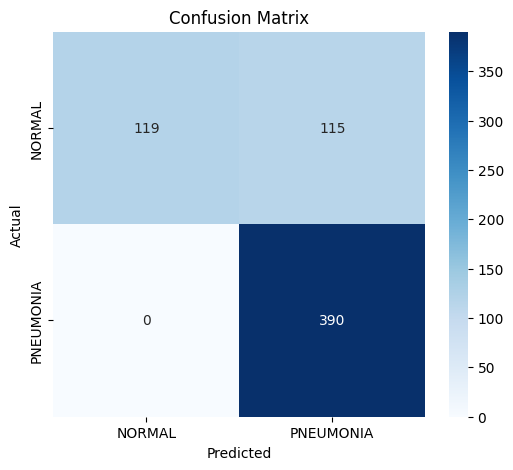

              precision    recall  f1-score   support

      NORMAL       1.00      0.51      0.67       234
   PNEUMONIA       0.77      1.00      0.87       390

    accuracy                           0.82       624
   macro avg       0.89      0.75      0.77       624
weighted avg       0.86      0.82      0.80       624



In [ ]:
def plot_history_pytorch(train_hist, val_hist):
    epochs = range(1, len(train_hist["loss"])+1)

    plt.figure(figsize=(18,5))

    # Acc
    plt.subplot(1,3,2)
    plt.plot(epochs, train_hist["acc"], label="Train", linewidth=2)
    plt.plot(epochs, val_hist["acc"],   label="Val",   linewidth=2)
    plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc")
    plt.legend(); plt.grid(alpha=0.3)

    # Loss
    plt.subplot(1,3,1)
    plt.plot(epochs, train_hist["loss"], label="Train", linewidth=2)
    plt.plot(epochs, val_hist["loss"],   label="Val",   linewidth=2)
    plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(alpha=0.3)


    plt.tight_layout()
    plt.show()

plot_history_pytorch(train_history, val_history)

# ===== 혼동행렬 + 분류 리포트 =====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))
